In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2

## Load the data

In [2]:
fname = "data.csv"
df = pd.read_csv(fname)

df.head()

,language,file_body
0,JavaScript,// Functions as values of a variable\nvar cube...
1,JavaScript,// Functions as values of a variable\nvar cube...
2,JavaScript,function median(ary) {\n if (ary.length == ...
3,JavaScript,"[\n null,\n 4,\n 3.5,\n 2.1\n]\n"
4,JavaScript,(() => {\n 'use strict';\n\n // median :...


<div class="alert alert-block alert-info">
Goal is to classify language based on file_body.
    <br>
proj_id and file_id will be ignored throughout.
</div>

## Distribution of languages

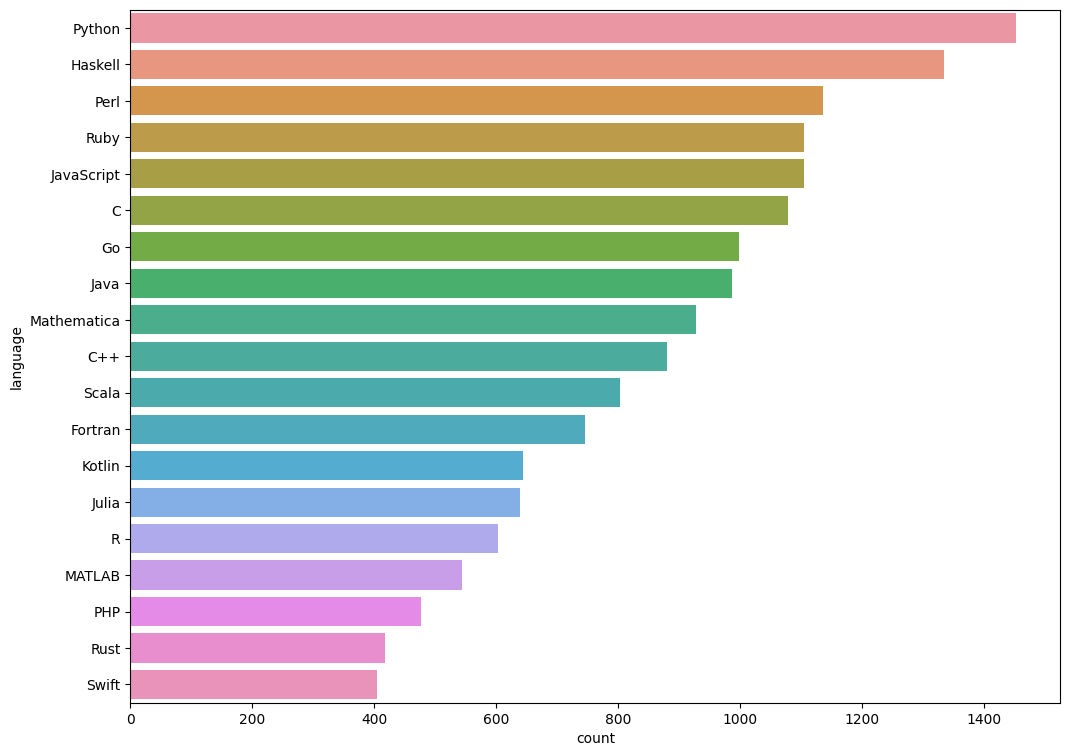

In [3]:
plt.figure(figsize = [12,9])
sns.countplot(y = df['language'], order = df['language'].value_counts().index);

plt.savefig('Dist.pdf')

Uneven distribution, some langues are under represented

<div class="alert alert-block alert-success">
Accounted for that in the train test split - Stratified
</div>

# Prepare the data

Possible issues:
- Empty cells DONE
- Duplicate entries DONE
- Potential issues with the writing? Two enters instead of one etc

Choices:
- Keep upper / lower case, I think it's important for Fortran

In [4]:
df['language'].describe()

count      16272
unique        19
top       Python
freq        1452
Name: language, dtype: object

### Drop empty cells

In [5]:
df.replace('', np.nan, inplace = True)
df.dropna(subset=['file_body'], inplace = True)
df['language'].describe()

count      16268
unique        19
top       Python
freq        1452
Name: language, dtype: object

### Drop duplicates

In [6]:
df.drop_duplicates(subset = ['file_body'], inplace = True);
df['language'].describe()

count      16204
unique        19
top       Python
freq        1447
Name: language, dtype: object

### Train / Test split
<div class="alert alert-block alert-success">
Introduced Stratification on language to deal with uneven categories.
<br>
    
<b> Explanation: </b> Stratified sampling aims at splitting a data set so that each split is similar with respect to something.

In a classification setting, it is often chosen to ensure that the train and test sets have approximately the same percentage of samples of each target class as the complete set.
</div>

In [7]:
x_train, x_test, y_train, y_test = train_test_split(df['file_body'], 
                                                    df['language'], 
                                                    test_size=0.2, 
                                                    random_state=8,
                                                   stratify = df['language'])

#### Stratified (top) vs unstratified (bottom), cf data examination above

Dataset is quite large, train on 5% of it, to conserve time

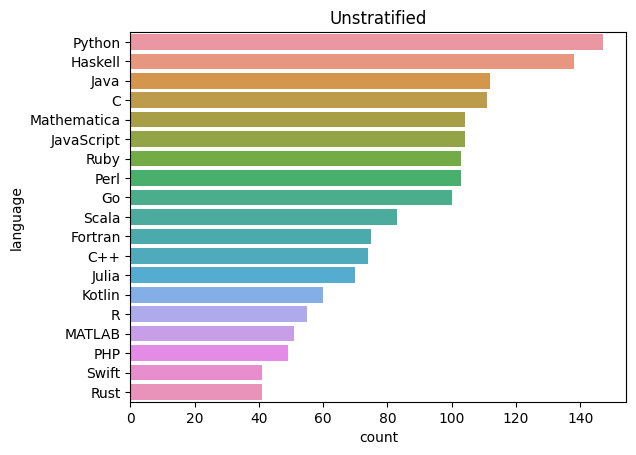

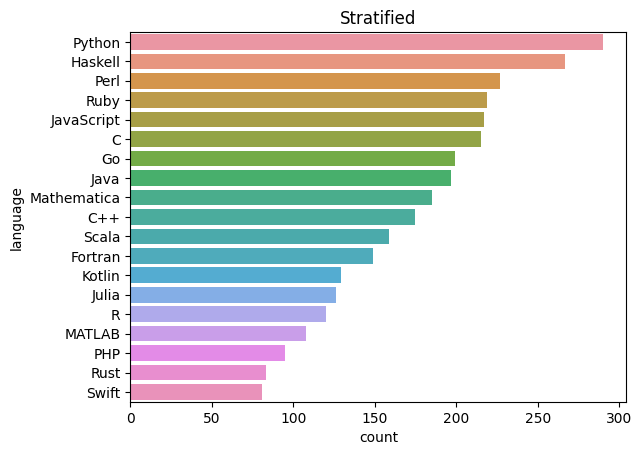

In [8]:
y_train0, y_test0 = train_test_split(df['language'], 
                                   test_size=0.1)
plt.figure()
sns.countplot(y = y_test0, order = y_test0.value_counts().index);
plt.title('Unstratified')
plt.savefig('unstrat.pdf')

plt.figure()
plt.title('Stratified')
sns.countplot(y = y_test, order = y_test.value_counts().index);
plt.savefig('strat.pdf')

## Text into features

Options considered:
1. One hot encoding - Issue: As it's binary, the context of words will be lost -> bad
2. Bag of Words - Counts frequency of words, rather than the sole existence. Not ordered. Issues: Ignores word ordering -> bad (apparently, can be high dimensional, but I'm not sure what that means... big?)
3. TF-IDF: Term Frequency - Inverse Document Frequency - 
    - IDF - good, makes common words across all documents insignificant, and rare one significant
    - TF - happens locally, in a sentence
    Issues - no ordering still, but improves on the BoW
    
Go with TF-IDF, no time to explore this further

In [9]:
# Token pattern veruy much not original
token_pattern = r"""([A-Za-z_]\w*\b|[!\#\$%\&\*\+:\-\./<=>\?@\\\^_\|\~]+|[ \t\(\),;\{\}\[\]"'`])"""

# prepare tfidf transofrmation
tfidf = TfidfVectorizer(ngram_range = (1,3), # 3 seems like enough for languages...
                        token_pattern = token_pattern,
                        stop_words = None,  
                        lowercase = False,  # Upper case can matter (Fortran?)
                        max_df = 0.8,       # if more than the fraction, remove from doc
                        min_df = 10,        # At least 10 occurences across documents
                        max_features = 300, # 300 feels like a fair amount
                        sublinear_tf=True)

# Get train features
features_train = tfidf.fit_transform(x_train).toarray()
labels_train = y_train
print(features_train.shape)

# Get test features
features_test = tfidf.transform(x_test).toarray()
labels_test = y_test
print(features_test.shape)

(12963, 300)
(3241, 300)


In [10]:
for language in df['language'].unique():
    features_chi2 = chi2(features_train, labels_train == language)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names_out())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    trigrams = [v for v in feature_names if len(v.split(' ')) == 3]
    print("# '{}' category:".format(language))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-5:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-2:])))
    print("  . Most correlated trigrams:\n. {}".format('\n. '.join(trigrams[-2:])))
    print("")

# 'JavaScript' category:
  . Most correlated unigrams:
. #
. ;
. //
. function
. var
  . Most correlated bigrams:
. ( '
. ) ;
  . Most correlated trigrams:
.   //
. var  

# 'Swift' category:
  . Most correlated unigrams:
. //
. ;
. println
. Int
. var
  . Most correlated bigrams:
. ) ;
. println (
  . Most correlated trigrams:
.   ->
. var  

# 'Python' category:
  . Most correlated unigrams:
. '
. import
. in
. print
. def
  . Most correlated bigrams:
. ( '
. ) :
  . Most correlated trigrams:
.   in
. def  

# 'Java' category:
  . Most correlated unigrams:
. println
. ;
. int
. new
. String
  . Most correlated bigrams:
. println (
. ) ;
  . Most correlated trigrams:
. int  
. ( ) ;

# 'C++' category:
  . Most correlated unigrams:
. ::
. int
. include
. <<
. std
  . Most correlated bigrams:
. ) {
. std ::
  . Most correlated trigrams:
.   <<
. <<  

# 'Ruby' category:
  . Most correlated unigrams:
. ?
. #
. def
. end
. |
  . Most correlated bigrams:
. ) ;
. ) .
  . Most correlated tri

<div class="alert alert-block alert-info">
   <b> TODO: </b> Pretty sure these combinations don't occur naturally...
    if time allows
    <br>
    eg. Python for in?
</div>

<div class="alert alert-block alert-warning">
Are symbols like ",: etc. ignored...?
<br>
I think I fixed it with tokenisation.
</div>

## Save the output

In [11]:
# X_train
with open('Pickles/x_train.pickle', 'wb') as output:
    pickle.dump(x_train, output)
    
# X_test    
with open('Pickles/x_test.pickle', 'wb') as output:
    pickle.dump(x_test, output)
    
# y_train
with open('Pickles/y_train.pickle', 'wb') as output:
    pickle.dump(y_train, output)
    
# y_test
with open('Pickles/y_test.pickle', 'wb') as output:
    pickle.dump(y_test, output)
    
# df
with open('Pickles/df.pickle', 'wb') as output:
    pickle.dump(df, output)
    
# features_train
with open('Pickles/features_train.pickle', 'wb') as output:
    pickle.dump(features_train, output)

# labels_train
with open('Pickles/labels_train.pickle', 'wb') as output:
    pickle.dump(labels_train, output)

# features_test
with open('Pickles/features_test.pickle', 'wb') as output:
    pickle.dump(features_test, output)

# labels_test
with open('Pickles/labels_test.pickle', 'wb') as output:
    pickle.dump(labels_test, output)
    
# TF-IDF object
with open('Pickles/tfidf.pickle', 'wb') as output:
    pickle.dump(tfidf, output)